## 神经网络实现文本情感分类


### 运行环境

docker image `tensorflow/tensorflow`, Python 3.4.3

In [1]:
%matplotlib inline
from collections import Counter
import time

import jieba
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

1.0.1


### 语料处理

* 去除空格/数字/部分标点/少量stopwords
    * 目的是不让这些与情感色彩无关的数据稀释了有效信息
* 变长度的句子不便作为神经网络的输入, 因此需先处理为固定长度. 
    * 超过固定长度的, 直接截断; 小于固定长度的, 用 padding 补齐.
* 将词转换为词序号


In [2]:
IGNORE = ' \n，。、：,的了是我很在都有就'  # 忽略的字符
DOC_LENGTH = 20  # 预设的固定句子长度
PADDING = '<PD>'  # 句子长度不足时的占位符

def read_data(file):
    """从文件读取样本, 去除忽略字符, 得到二维词列表
    args: file - 文件名
    returns: docs - 各样本的词列表"""
    docs = []
    with open(file, encoding='utf-8') as f:
        lines = f.readlines()
    for line in lines:
        words = []
        for word in jieba.cut(line):
            if (word not in IGNORE) and not word.isdigit():
                words.append(word)
        docs.append(words)
    return docs

def fix_length(docs):
    """将所有样本的词列表调整为固定长度"""
    for i in range(len(docs)):
        if len(docs[i]) < DOC_LENGTH:
            docs[i].extend([PADDING] * (DOC_LENGTH - len(docs[i])))
        else:
            docs[i] = docs[i][:DOC_LENGTH]
    # assert all([len(d) == DOC_LENGTH for d in docs])
    return docs

def get_word_counter(docs):
    all_words = [w for doc in docs for w in doc]  # flatten the list
    return Counter(all_words)

def build_vocab(word_cnt, limit=3):
    """建立词表, 仅计入出现次数超过设定值(默认为3)的词"""
    vocab = ['UNK']
    for i in word_cnt.most_common():
        if i[1] > limit:
            vocab.append(i[0])
        else:
            break
    return vocab

In [3]:
basedir = '../ch2/_corpus/'
keys = ('pos_train', 'neg_train', 'pos_test', 'neg_test')

files = {k: basedir + k + '.txt' for k in keys}
docs = {k: read_data(files[k]) for k in keys}

train_docs = docs['pos_train'] + docs['neg_train']
train_docs = fix_length(train_docs)
train_labels = [1] * len(docs['pos_train']) + [0] * len(docs['neg_train'])

test_docs = docs['pos_test'] + docs['neg_test']
test_docs = fix_length(test_docs)
test_labels = [1] * len(docs['pos_test']) + [0] * len(docs['neg_test'])

# 由训练样本集建立词表
word_cnt = get_word_counter(train_docs)
vocab = build_vocab(word_cnt)
vocab_size = len(vocab)
idx_dict = dict(zip(vocab, range(vocab_size)))  # 由词映射到词序号的字典
vocab_size

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.742 seconds.
Prefix dict has been built succesfully.


8311

In [4]:
print(word_cnt.most_common(50))

[('<PD>', 100462), ('酒店', 4574), ('也', 4246), ('不', 3666), ('！', 3520), ('不错', 3378), ('房间', 3317), ('.', 3225), ('好', 3063), ('还', 3008), ('没有', 2922), ('这', 2261), ('和', 2215), ('比较', 2015), ('看', 1900), ('可以', 1882), ('感觉', 1823), ('服务', 1784), ('买', 1781), ('还是', 1578), ('到', 1558), ('本书', 1530), ('非常', 1515), ('就是', 1514), ('住', 1510), ('说', 1503), ('用', 1476), ('一个', 1390), ('但', 1330), ('入住', 1308), ('书', 1283), ('月', 1219), ('这个', 1216), ('去', 1196), ('要', 1195), ('人', 1188), ('但是', 1175), ('系统', 1155), ('有点', 1133), ('给', 1116), ('没', 1112), ('一般', 1064), ('上', 1058), ('对', 1056), ('我们', 1046), ('价格', 1031), ('喜欢', 1019), ('不是', 1004), ('日', 983), ('太', 956)]


In [5]:
def docs2idxes(docs):
    """把词列表的列表转换为序号列表的列表"""
    idxes = []
    for doc in docs:
        idxes_of_one_doc = []
        for word in doc:
            idx = idx_dict[word] if (word in vocab) else 0
            idxes_of_one_doc.append(idx)
        idxes.append(idxes_of_one_doc)
    return idxes

train_idxes = docs2idxes(train_docs)
inputs_train = np.asarray(train_idxes)
labels_train = np.asarray(train_labels)

test_idxes = docs2idxes(test_docs)
inputs_test = np.asarray(test_idxes)
labels_test = np.asarray(test_labels)

### 定义神经网络

* 输入: 词序号数组
* 中间层: 词向量, 可以再接一个隐层
* 输出: 情感分类


In [6]:
word_embedding_dim = 15
hidden_dim = 15

tf.reset_default_graph()
word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))
inputs = tf.placeholder(tf.int32, shape=[None, DOC_LENGTH], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

input_embeds = tf.nn.embedding_lookup(word_embedding, inputs)
doc_embeds = tf.reduce_sum(input_embeds, axis=1)  # 样本的"平均词向量"
input_embeds, doc_embeds

(<tf.Tensor 'embedding_lookup:0' shape=(?, 20, 15) dtype=float32>,
 <tf.Tensor 'Sum:0' shape=(?, 15) dtype=float32>)

In [7]:
hidden = tf.layers.dense(doc_embeds, hidden_dim, activation=tf.tanh)
raw_output = tf.layers.dense(hidden, 2)
output = tf.nn.softmax(raw_output)
raw_output.shape, labels_train.shape

(TensorShape([Dimension(None), Dimension(2)]), (24586,))

In [8]:
# cost function, 求 reduce_mean 不是必需
cost = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=raw_output, labels=labels))

### 训练

* 随机梯度下降, 每个训练步读一个样本


In [9]:
def evaluate_model(sess, inputs_, labels_, print_matrix=False):
    """评估模型指标, 并打印输出"""
    pred_prob = sess.run(output, feed_dict={inputs:inputs_, labels:labels_})
    preds = np.asarray((pred_prob[:, 1] > 0.5), dtype=int)
    mat = sess.run(tf.confusion_matrix(labels_, preds))
    tn, fp, fn, tp = mat.reshape(4)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if print_matrix:
        print(' confusion matrix:\n', mat)
    print(' precision {:.3f}, recall {:.3f}'.format(precision, recall))
    # return preds, mat, precision, recall

In [15]:
learning_rate = 0.3
batch_size = 100
epochs = 3000
print_cost_every = 100

feed_train = {inputs: inputs_train, labels: labels_train}
feed_test = {inputs: inputs_test, labels: labels_test}

sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

costs_train = []
costs_test = []
start_time = time.time()

num_inputs = len(labels_train)
order = np.arange(num_inputs)
np.random.shuffle(order)

try:
    for i in range(epochs):
        if i % print_cost_every == 0:
            cost_train = sess.run(cost, feed_dict=feed_train)
            cost_test = sess.run(cost, feed_dict=feed_test)
            print('Epoch {:03d} cost: train {:.3f} / test {:.3f}'.format(
                i, cost_train, cost_test))
            costs_train.append(cost_train)
            costs_test.append(cost_test)
            evaluate_model(sess, inputs_test, labels_test)

        for j in range(0, num_inputs, batch_size):
            batch_index = order[j: j + batch_size]
            batch_inputs = inputs_train[batch_index]
            batch_labels = labels_train[batch_index]
            batch_feed = {inputs: batch_inputs, labels: batch_labels}
            sess.run(train_step, feed_dict=batch_feed)
except KeyboardInterrupt:
    print('Interrupted')
finally:
    end_time = time.time()
    print('\ntime: {:.2f} s'.format(end_time - start_time))

Round 000 cost: train 0.884 / test 0.883
 precision 0.471, recall 0.991
Round 100 cost: train 0.322 / test 0.435
 precision 0.874, recall 0.720
Round 200 cost: train 0.277 / test 0.513
 precision 0.736, recall 0.922
Round 300 cost: train 0.292 / test 0.601
 precision 0.783, recall 0.903
Round 400 cost: train 0.295 / test 0.646
 precision 0.759, recall 0.919
Round 500 cost: train 0.188 / test 0.571
 precision 0.929, recall 0.751
Round 600 cost: train 0.097 / test 0.517
 precision 0.904, recall 0.874
Round 700 cost: train 0.089 / test 0.541
 precision 0.898, recall 0.875
Round 800 cost: train 0.170 / test 0.627
 precision 0.807, recall 0.919
Round 900 cost: train 0.081 / test 0.578
 precision 0.894, recall 0.880
Round 1000 cost: train 0.087 / test 0.576
 precision 0.894, recall 0.895
Round 1100 cost: train 0.084 / test 0.662
 precision 0.911, recall 0.876
Round 1200 cost: train 0.074 / test 0.645
 precision 0.888, recall 0.906
Round 1300 cost: train 0.088 / test 0.654
 precision 0.912, r

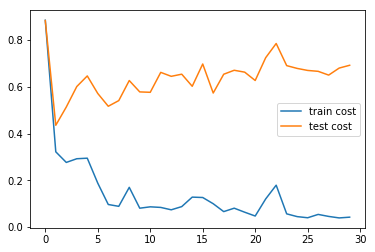

In [16]:
plt.plot(costs_train, label='train cost')
plt.plot(costs_test, label='test cost')
plt.legend();

### 评估

* 使用 tf 内置的 tf.confusion_matrix 方法

In [17]:
print('\n** train set **')
evaluate_model(sess, inputs_train, labels_train, print_matrix=True)
print('\n** test set **')
evaluate_model(sess, inputs_test, labels_test, print_matrix=True)


** train set **
 confusion matrix:
 [[12927    76]
 [  276 11307]]
 precision 0.993, recall 0.976

** test set **
 confusion matrix:
 [[5154  419]
 [ 531 4434]]
 precision 0.914, recall 0.893


### ChangeLog

* v0: 
  * 句长 20, 词向量维数 25, 无附加隐层, 随机梯度下降, 步长 0.003
  * 训练时间约 15 min
  * [test] precision: 0.7946, recall: 0.8834
* v0a:
  * v0 -> 词向量维数改为 100
  * precision: 0.8034, recall: 0.8363 
    * 奇怪 怎么比 v0 还下降了, 可能是随机性吧
* v1:
  * v0 -> 词向量维数 25, 增加一个隐层(25节点)
  * 训练时间 1h+
  * [test] precision: 0.9071, recall: 0.9007
  * 比朴素贝叶斯有明显提高
* v1a:
  * 看 cost 曲线, 怀疑有过拟合.
  * v1 -> 词向量维数和隐层节点数 25 -> 15
  * [test] precision: 0.8574, recall: 0.9275
* v1b:
  * v1 -> 句子长度 20 -> 40
  * [test] precision: 0.8493, recall: 0.5652
  * 句子长度增大, recall 反倒出了问题. 
    * 经检查, 原长度 < 20的句子, 训练集 recall 只有 0.25 左右
    * 猜测是增加太多的 padding 干扰了有效信息
    * 寻找最优的句子长度值?
* v1c:
  * v1 -> 词向量维数和隐层节点数 25 -> 40
  * 训练时间相比 v1 没有显著变化
  * [train] precision: 0.8887, recall: 0.9876
  * [test] precision: 0.8175, recall: 0.9212
  * cost 曲线波动性很大, 是否模型还未稳定收敛? 迭代步再加大可能好点?
* v1c1:
  * v1c -> 迭代步数 500 -> 1500, 步长 0.003 -> 0.002
  * [train] precision: 0.9390, recall: 0.9852
  * [test] precision: 0.8589, recall: 0.9120
* v1d:
  * v1 -> 词向量维数和隐层节点数 25 -> 15
  * [train] precision: 0.9931, recall: 0.9645
  * [test] precision: 0.9197, recall: 0.8810
* v2:
  * v1d -> 改为小批量梯度下降
  * 收敛时间明显缩短, 从 2-3 小时减少至不到半小时
* 有时间或考虑改进:
  * 正则化?
  * 寻找最优句子长度
  * 不同的隐层激活函数?